# HRD Status & PARP Inhibitor Sensitivity Analysis 🔬

**Objective**: Systematically explore the relationship between homologous recombination deficiency (HRD) status and PARP inhibitor response across cell lines and drugs.

---
---
---

## 1. Setup 📦

---

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import ptitprince as pt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# Computational Modules
from scipy.stats import mannwhitneyu, pearsonr, spearmanr, ttest_ind
from sklearn.preprocessing import RobustScaler, StandardScaler
import statsmodels.formula.api as smf

# Utils
from IPython.display import display, HTML, IFrame, Image
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load the pickled, analysis-ready datasets containing PARP inhibitor response metrics and HRD features.

---

In [2]:
# Define project root & load analysis-ready dataset
BASE_DIR = Path.cwd()
ccl_hrd_parpi_df = pd.read_pickle(BASE_DIR / 'utils' / 'ccl_hrd_parpi_df.pkl')

ccl_hrd_parpi_df.head(5)

,ModelID,name,auc,HRD_positive,HRD_BRCA,HRD_genomic_score,HRD_genomic,PatientID,CellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,RRID,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,SampleCollectionSite,SourceType,ModelType,ModelTreatment,GrowthPattern,OnboardedMedia,FormulationID,SerumFreeMedia,CCLEName,PediatricModelType,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMICID,scaled_auc,drug,lineage
0,ACH-000001,3-amino-benzamide,0.905995,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,Cell Line,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NIHOVCAR3_OVARY,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,-0.730048,3-amino-benzamide,Ovary/Fallopian Tube
1,ACH-000001,S-111,1.000000,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,Cell Line,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NIHOVCAR3_OVARY,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,0.246926,S-111,Ovary/Fallopian Tube
2,ACH-000001,iniparib,0.914447,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,Cell Line,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NIHOVCAR3_OVARY,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,-0.676116,iniparib,Ovary/Fallopian Tube
3,ACH-000001,niraparib,0.741783,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,Cell Line,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NIHOVCAR3_OVARY,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,-1.139504,niraparib,Ovary/Fallopian Tube
4,ACH-000001,olaparib,0.916763,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,Cell Line,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NIHOVCAR3_OVARY,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,-0.119605,olaparib,Ovary/Fallopian Tube


## 3. Cursory Explorations & Preprocessing 🔍

**Objective**: Examine total cell lines, drug coverage, HRD definitions, and other key features to establish a baseline understanding of the engineered dataset and execute any remaining preprocessing steps.

**Methodology**: First, the integrated PARP inhibitor response dataset is loaded and inspected to confirm structural integrity, including dimensions, identifiers, and variable types. Second, redundant, administrative, and highly sparse metadata fields are removed to reduce noise while preserving features with analytical value. Third, cohort composition is characterized by quantifying drug coverage across compounds and within cell lines to evaluate comparability and patterns of missingness. Fourth, baseline response behavior is examined through distributional summaries and dispersion metrics, establishing the scale, variability, and heterogeneity of AUC measurements prior to HRD-stratified analyses.

---

### 3a. Dataset Inspection

In [3]:
ccl_hrd_parpi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6784 entries, 0 to 6796
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ModelID                 6784 non-null   object  
 1   name                    6784 non-null   object  
 2   auc                     6784 non-null   float64 
 3   HRD_positive            6784 non-null   float64 
 4   HRD_BRCA                6784 non-null   float64 
 5   HRD_genomic_score       6784 non-null   float64 
 6   HRD_genomic             6784 non-null   float64 
 7   PatientID               6784 non-null   object  
 8   CellLineName            6784 non-null   object  
 9   DepmapModelType         6784 non-null   object  
 10  OncotreeLineage         6784 non-null   object  
 11  OncotreePrimaryDisease  6784 non-null   object  
 12  OncotreeSubtype         6784 non-null   object  
 13  OncotreeCode            6549 non-null   object  
 14  PatientSubtypeFeatures  309 n

The dataset encompasses 6784 rows, each representing a unique cell line model and PARP inhibitor combination. These records are described by the following feature set:

Cell Line ID & Drug Response Data:
- `ModelID` – unique DepMap identifier for each cell line
- `name` – PARP inhibitor compound name
- `auc` – Area under the curve from PRISM drug response; lower = more sensitive

HRD Status (engineered in the first notebook):
- `HRD_positive` – unified HRD label combining BRCA mutation + genomic scar
- `HRD_BRCA` – BRCA1/2 mutation–defined HRD
- `HRD_genomic_score` – continuous composite genomic scar metric
- `HRD_genomic` – binary genomic scar–derived HRD

Cell Line Metadata:
- `PatientID` – original patient identifier from whom the model was derived
- `CellLineName` / `StrippedCellLineName` / `CCLEName` – names and aliases for the cell line
- `DepmapModelType` / `ModelType` / `EngineeredModel` / `EngineeredModelDetails` – describes how the cell line was derived (e.g., standard, engineered)
- `GrowthPattern` / `OnboardedMedia` / `SerumFreeMedia` / `FormulationID` / `PlateCoating` – experimental or culture conditions

Disease / Tissue Annotation:
- `OncotreeLineage` / `OncotreePrimaryDisease` / `OncotreeSubtype` / `OncotreeCode` – tissue/cancer classification using OncoTree ontology
- `TissueOrigin` – not available in this dataset
- `PatientSubtypeFeatures` / `ModelSubtypeFeatures` – more granular subtype annotations
- `PrimaryOrMetastasis` / `SampleCollectionSite` – whether the tumor is primary or metastatic and collection site

Patient Demographics & Clinical Info:
- `Age` / `AgeCategory` / `Sex` / `PatientRace` – demographics
- `Stage` / `StagingSystem` / `PatientTumorGrade` – tumor stage and grade; mostly missing
- `PatientTreatmentStatus` / `PatientTreatmentType` / `PatientTreatmentDetails` / `PatientTreatmentResponse` – clinical treatment info; sparse

External Identifiers:
- `RRID` / `WTSIMasterCellID` / `SangerModelID` / `COSMICID` / `ModelIDAlias` / `HCMIID` – cross-reference IDs across databases (CCLE, COSMIC, HCMI, Sanger, etc.)

Other:
- `SourceType` / `SourceDetail` / `CatalogNumber` – origin of the sample or vendor info.
- `PublicComments` – notes/comments about the cell line
- `PediatricModelType` – flags pediatric-derived models
- `ModelAvailableInDbgap` – availability for dbGaP access


**Summary**:

- The subset relevant for the primary PARPi-HRD study (the first two feature categories outlined above) is structurally sound and analysis-ready.
- Many patient-level and clinical features are missing and unreliable for further analysis.
- Experimental / culture metadata are mostly complete and therefore may enable adjustment for experimental cofounders.
- Multiple redundant naming/ID columns exist and could be pruned for simplicity. 
- Although HRD status features are all reported as *float64* values, only `HRD_genomic_score` is a continuous variable while the rest are binaries and can be coded accordingly.
- Despite sparse data, model treatment info could be useful as pre-treated models might show a different influence in drug sensitivity. Furthermore, patient subtype features can be used to encode biologically meaningful annotations. So these could be initially kept for further analyses.

### 3b. Feature Pruning

In [4]:
### Perform appropriate cleaning measures based on preliminary inspection above 

# Columns that are entirely or almost entirely missing
mostly_missing_cols = [
    'TissueOrigin',
    'ModelDerivationMaterial',
    'PlateCoating',
    'EngineeredModel',
    'EngineeredModelDetails',
    'CulturedResistanceDrug',
    'StagingSystem',
    'PatientTumorGrade'
]

# Highly sparse clinical/treatment variables (insufficient for analysis)
very_sparse_clinical_cols = [
    'PatientTreatmentStatus',
    'PatientTreatmentType',
    'PatientTreatmentDetails',
    'PatientTreatmentResponse',
    'Stage'
]

# Administrative / vendor / logistics info
administrative_cols = [
    'CatalogNumber',
    'SourceDetail',
    'PublicComments',
    'HCMIID',
    'ModelIDAlias'
]

# Redundant identifiers or naming aliases
redundant_id_cols = [
    'StrippedCellLineName',
]

# Combine drop list
cols_to_drop = (
    mostly_missing_cols
    + very_sparse_clinical_cols
    + administrative_cols
    + redundant_id_cols
)

# Drop irrelevant features (check first, in case of version differences)
cols_to_drop = [col for col in cols_to_drop if col in ccl_hrd_parpi_df.columns]
ccl_hrd_parpi_df = ccl_hrd_parpi_df.drop(columns=cols_to_drop).copy()

To improve analytical reliability and reduce noise, variables with extremely high levels of missingness or no recorded values were removed. Fields that primarily served as redundant identifiers or administrative references were also excluded, since they do not contribute independent biological or pharmacologic information for the present study.

Two sparse attributes (`ModelTreatment` & `PatientSubtypeFeatures`) were intentionally retained despite limited coverage. Although unsuitable for broad statistical modeling, they may contain high-value contextual information capable of explaining unusual response patterns or enabling focused subgroup investigations in future work. Preserving them maintains optionality without affecting the integrity of the primary analyses.

### 3c. Cell Lines & Drug Coverage

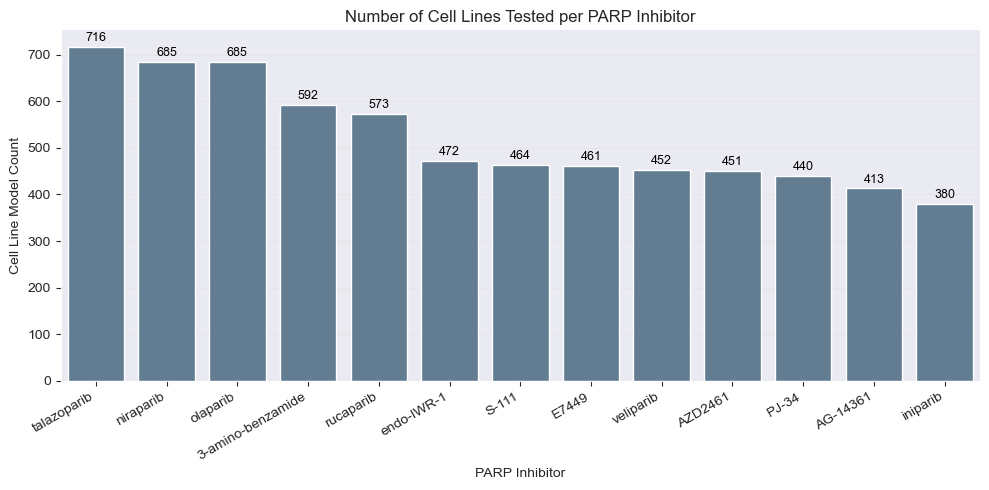

In [5]:
# Set up figure 
plt.figure(figsize=(10, 5))

# Plot number of cells tested per drug
ax = sns.countplot(
    data=ccl_hrd_parpi_df,
    x='name',
    order=(ccl_hrd_parpi_df['name'].value_counts().sort_values(ascending=False).index),
    color='#5A7D9A'
)

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        xytext=(0, 2),
        textcoords='offset points'
    )

# Labels and formatting
ax.set_title('Number of Cell Lines Tested per PARP Inhibitor')
ax.set_xlabel('PARP Inhibitor')
ax.set_ylabel('Cell Line Model Count')
plt.xticks(rotation=30, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

Drug representation is uneven across the screening panel. Talazoparib, niraparib, and olaparib were evaluated in the largest number of models, whereas agents such as AG-14361 and iniparib were tested in substantially smaller subsets.

This heterogeneity has practical implications for inference. Compounds with broader coverage provide greater statistical power and more stable effect estimates, while drugs screened in fewer lines may yield noisier comparisons and reduced sensitivity for detecting HRD-associated differences. As a result, both pooled and drug-specific analyses should consider sample size variability.

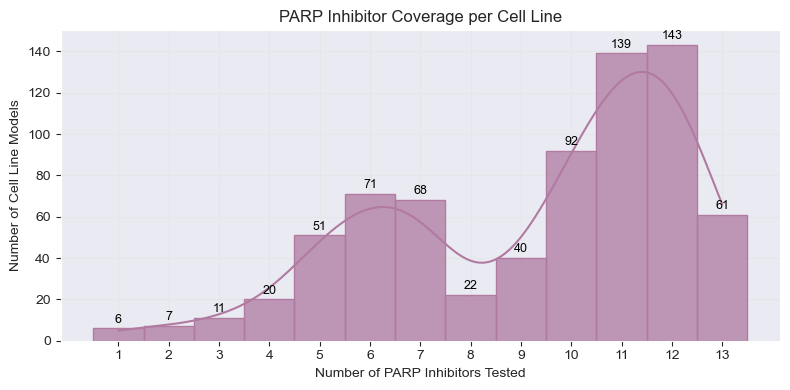

In [6]:
# Compute drug coverage per cell line
drug_counts = (
    ccl_hrd_parpi_df
    .groupby('ModelID')['name']
    .nunique()
    .reset_index(name='drug_count')
)
# Set up figure
plt.figure(figsize=(8, 4))

# Histogram with integer-aligned bins
ax = sns.histplot(
    data=drug_counts,
    x='drug_count',
    bins=np.arange(0.5, 14.5, 1),
    stat='count',
    color='#B07AA1',
    kde=True,
    edgecolor='#B07AA1',
    alpha=0.75
)

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        xytext=(0, 2),
        textcoords='offset points'
    )

        
# Labels and formatting
plt.title('PARP Inhibitor Coverage per Cell Line')
plt.xlabel('Number of PARP Inhibitors Tested')
plt.ylabel('Number of Cell Line Models')
plt.xticks(range(int(drug_counts['drug_count'].min()),
                 int(drug_counts['drug_count'].max()) + 1))
plt.tight_layout()
plt.show()

The distribution of the number of unique PARP inhibitors tested per cell line is shown above. Because drug coverage is a discrete integer quantity, the histogram was constructed with one bin per compound, allowing direct interpretation of screening depth. Most cell lines were profiled against a large fraction of the PARP inhibitor panel. The distribution is distinctly bimodal, with a dominant concentration of models tested against approximately 10–12 compounds and a secondary cluster evaluated across a more limited subset (roughly 5–7 inhibitors). Only a small number of models exhibit very low coverage, resulting in a sparse low-coverage tail.

This structure suggests that cross-drug comparisons are generally feasible. Cell lines with high screening coverage support within-model comparisons of relative drug sensitivity, whereas partially profiled models may introduce additional missingness or variance in drug-specific analyses. Accordingly, downstream modeling may benefit from sensitivity analyses that restrict to broadly screened cell lines to confirm the robustness of observed associations. It is important to note that, 61 cell line models were screened for all 13 PARP inhibitors available in the dataset, enabling potential within-model comparisons across the drugs.

### 3d. HRD Landscape Across the Screen

##### Overall HRD Prevalence By Definition

HRD_positive    0.853626
HRD_genomic     0.835200
HRD_BRCA        0.061616
dtype: float64


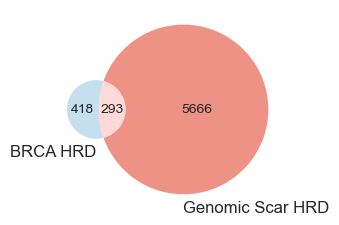

In [7]:
# Proportion of models in each HRD definition
hrd_summary = (
    ccl_hrd_parpi_df[['HRD_positive', 'HRD_BRCA', 'HRD_genomic']]
    .mean()
    .sort_values(ascending=False)
)
print(hrd_summary)

# Visualize overlap between both HRD definitions
plt.figure(figsize=(3,3))
venn2(
    subsets=(ccl_hrd_parpi_df['HRD_BRCA'].astype(bool).sum(), ccl_hrd_parpi_df['HRD_genomic'].astype(bool).sum(), 
             (ccl_hrd_parpi_df['HRD_BRCA'].astype(bool) & ccl_hrd_parpi_df['HRD_genomic'].astype(bool)).sum()),
    set_labels=('BRCA HRD', 'Genomic Scar HRD'),
    set_colors=('#9ECAE1', '#E24A33'),
    alpha=0.6
)
plt.show()

This table summarizes the prevalence of homologous recombination deficiency (HRD) across different operational definitions. The unified HRD label (`HRD_positive`) captures the largest fraction of models (85.4%) because it combines BRCA mutation–driven and genomic scar–based evidence. The genomic classifier alone (`HRD_genomic`) identifies a similarly broad set of candidates (83.5%), while BRCA mutation–defined HRD (`HRD_BRCA`) represents a smaller, highly specific subset (6.2%).

Quantifying these proportions is critical for downstream analyses. Class balance directly affects statistical power, variance, and effect estimation in comparative and predictive modeling. The large size of the HRD-positive group suggests that broad comparisons will be feasible, though careful consideration of subgroup heterogeneity may be warranted.

##### BRCA vs Genomic HRD Concordance

In [8]:
# Crosstab of the two HRD mechanisms
concordance_table = pd.crosstab(
    ccl_hrd_parpi_df['HRD_BRCA'],
    ccl_hrd_parpi_df['HRD_genomic'],
    rownames=['BRCA'],
    colnames=['Genomic']
)

concordance_table

Genomic,0.0,1.0
BRCA,,
0.0,993,5373
1.0,125,293


This contingency table compares HRD cells derived from BRCA mutations (`HRD_BRCA`) and the genomic scar classifier (`HRD_genomic`). Concordant classifications indicate consistent biological signals of homologous recombination deficiency, while discordant cases suggest alternative mechanisms of pathway disruption or residual genomic scars independent of BRCA status.

Notably, the genomic-only group (BRCA–negative / genomic–positive) highlights the additional models captured by the composite scar score, demonstrating the value of incorporating both mutation and genomic evidence for more comprehensive HRD detection.

##### HRD Frequency by Cancer Lineage

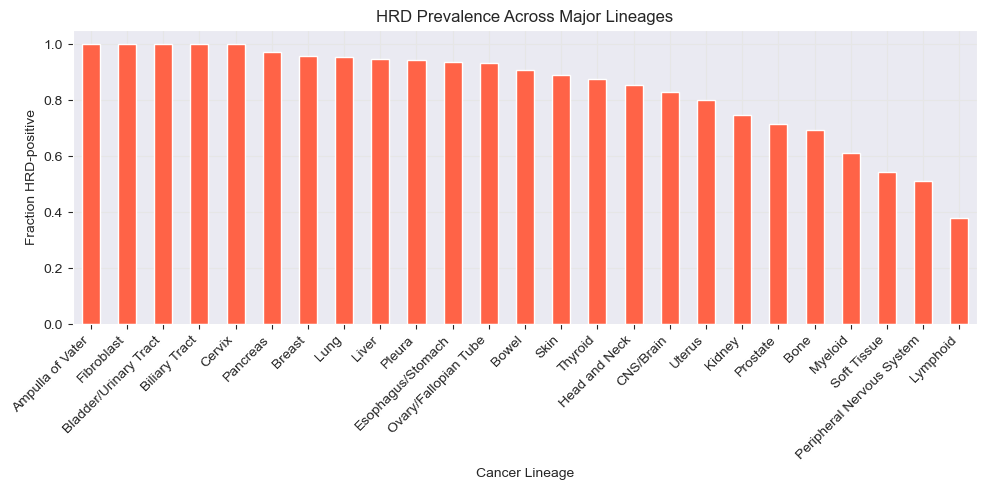

In [9]:
lineage_hrd = (
    ccl_hrd_parpi_df
    .groupby('OncotreeLineage')['HRD_positive']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
ax = lineage_hrd.plot(kind='bar', color='tomato')

plt.title('HRD Prevalence Across Major Lineages')
plt.ylabel('Fraction HRD-positive')
plt.xlabel('Cancer Lineage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The plot above shows the fraction of cell line models classified as HRD-positive across major cancer lineages. HR deficiency is generally high, with most tissues above 85%, but there is notable variation. Lineages such as Ampulla of Vater, Fibroblast, Bladder/Urinary Tract, Biliary Tract, and Cervix are uniformly HRD-positive, while others, including Lymphoid, Peripheral Nervous System, Soft Tissue, and Myeloid, exhibit substantially lower prevalence.

Examining lineage-specific prevalence is important because overrepresentation of HRD-positive models in certain tissues could confound downstream analyses. Naive comparisons of PARP inhibitor response might partly reflect tissue-specific biology rather than homologous recombination deficiency itself.

Future modeling should account for this imbalance by including lineage as a covariate, performing stratified analyses, or limiting comparisons to lineages with sufficient representation. Doing so ensures that observed associations between HRD status and PARPi sensitivity reflect true repair deficiency rather than tissue composition effects.

### 3e. Drug Response Metric (AUC) Characteristics

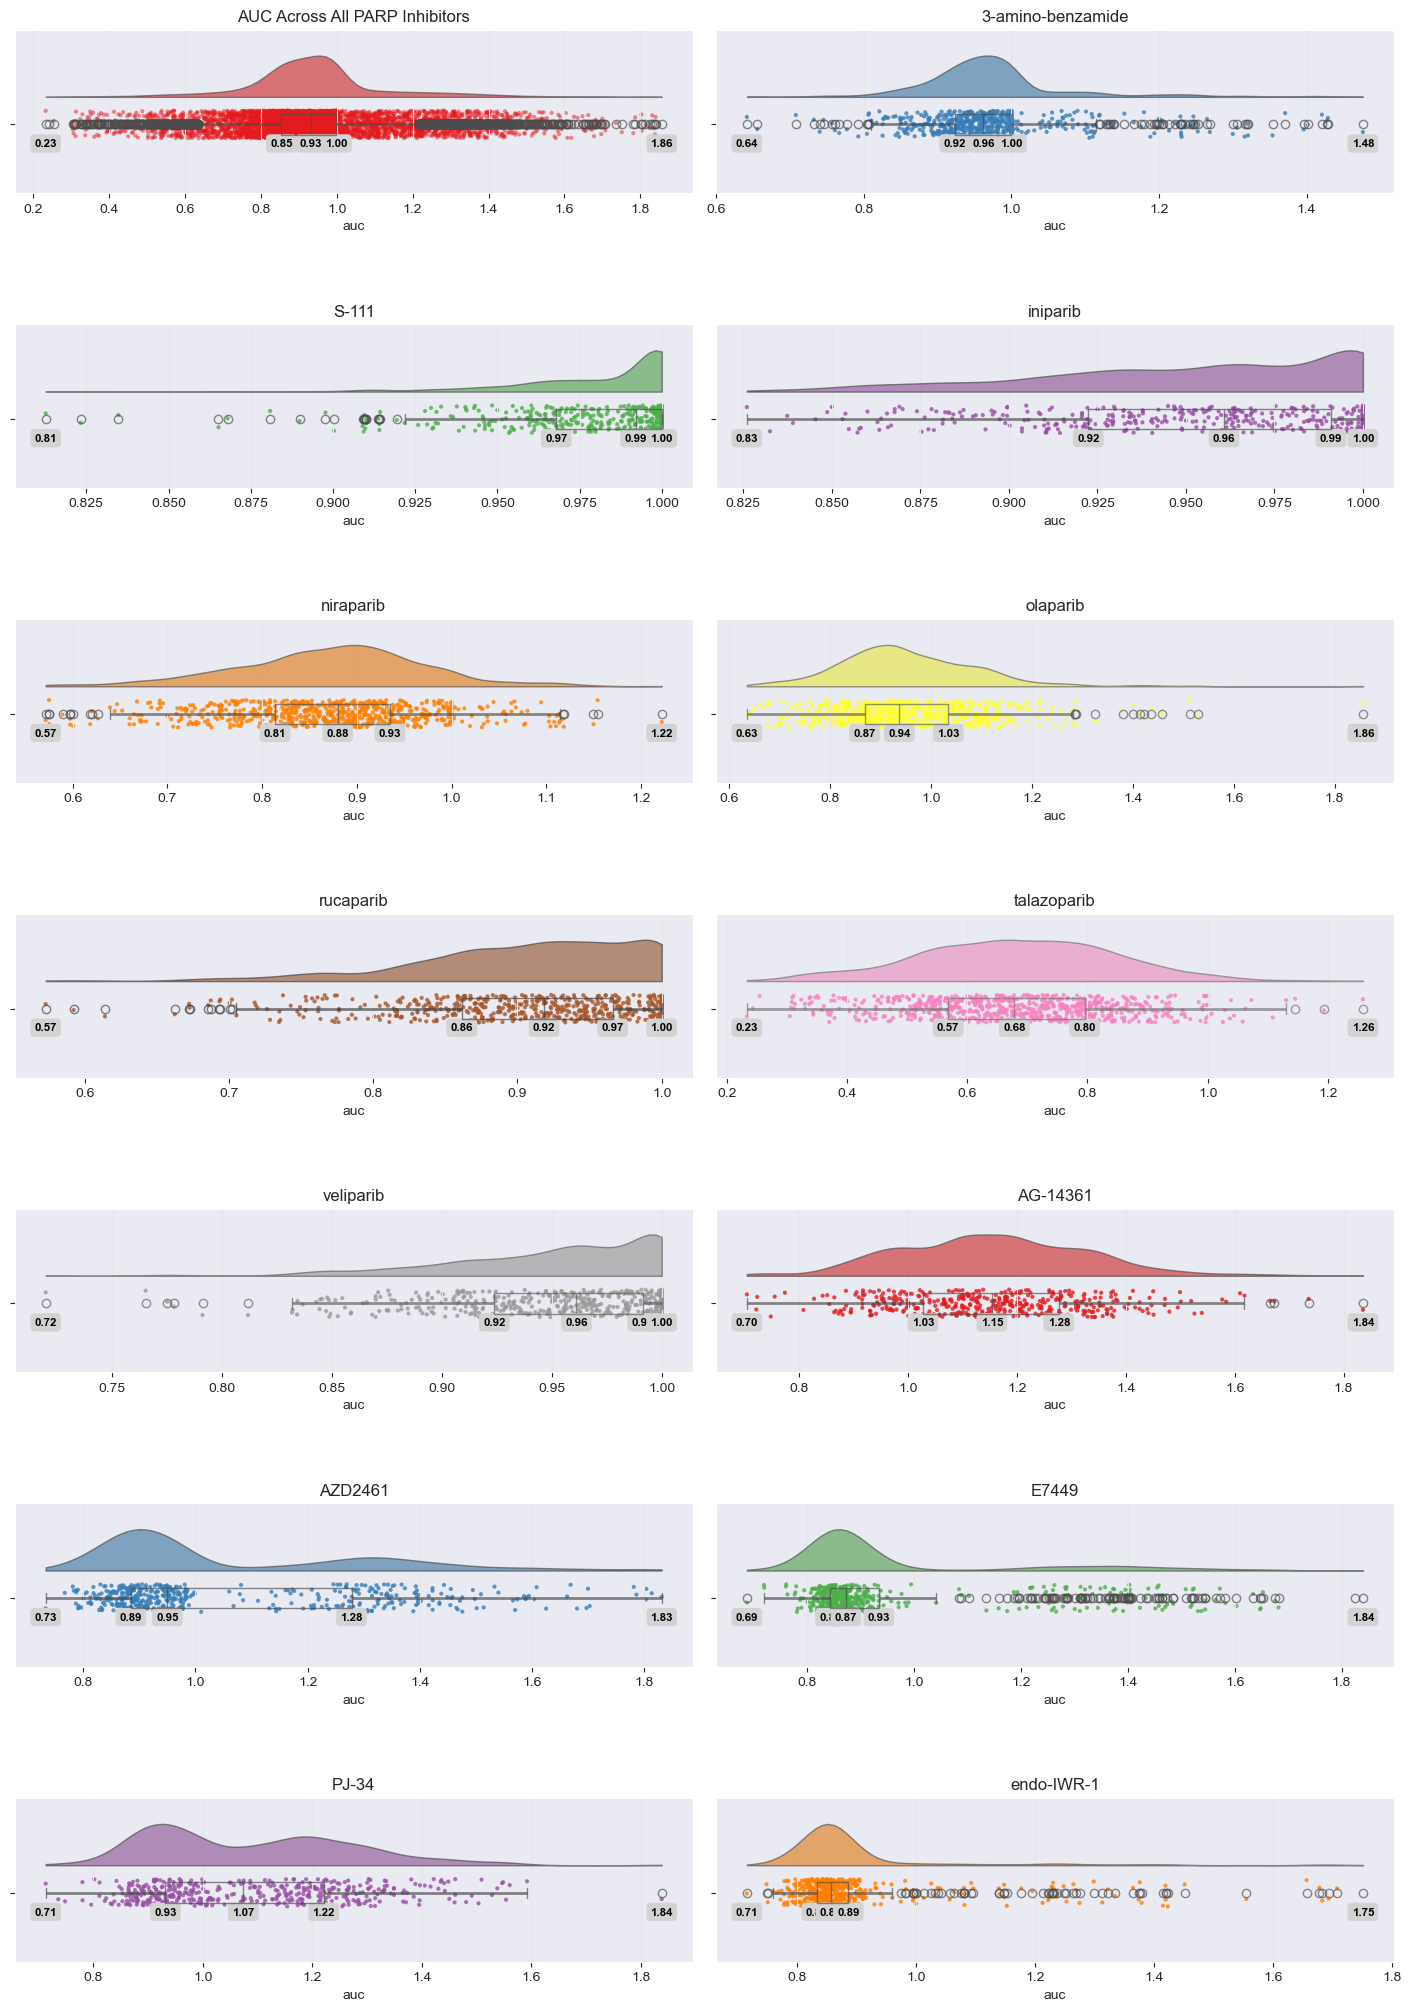

In [10]:
# Set up figure & individual subplots
fig, axs = plt.subplots(7, 2, figsize=(14, 20), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
axs = axs.flatten()  # for easy indexing
rc_palettes = sns.color_palette('Set1', n_colors=14)

# Plot AUCs across all drugs
cloud_all = pt.RainCloud(
    data=ccl_hrd_parpi_df,
    y='auc',
    bw=0.2,
    alpha=0.65,
    rain_alpha=0.5,
    width_viol=0.6,
    orient='h',
    palette=[rc_palettes[0]],
    hue=0,
    ax=axs[0],
)

# Add quartile labels
desc_stats = ccl_hrd_parpi_df['auc'].quantile([0, 0.25, 0.5, 0.75, 1])
for stat in desc_stats:
    cloud_all.text(
        s=f"{stat:.2f}",
        x=stat,
        y=0.16,
        ha='center',
        size='small',
        color='black',
        weight='semibold',
        bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
    )
axs[0].set_title('AUC Across All PARP Inhibitors')

# Plot AUCs for each drug
drug_list = ccl_hrd_parpi_df['name'].unique()
for i, drug in enumerate(drug_list):
    
    # Subset for specific drug
    drug_data = ccl_hrd_parpi_df[ccl_hrd_parpi_df['name'] == drug]

    # Raincloud
    cloud = pt.RainCloud(
        data=drug_data,
        y='auc',
        bw=0.2,
        alpha=0.65,
        rain_alpha=0.8,
        width_viol=0.6,
        orient='h',
        hue=i,
        palette=[rc_palettes[i+1]],
        ax=axs[i+1],
    )

    # Add quartile labels
    desc_stats = drug_data['auc'].quantile([0, 0.25, 0.5, 0.75, 1])
    for stat in desc_stats:
        cloud.text(
            s=f"{stat:.2f}",
            x=stat,
            y=0.16,
            ha='center',
            size='small',
            color='black',
            weight='semibold',
            bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
        )
    axs[i+1].set_title(drug)

plt.show()

PRISM AUC distributions for all PARP inhibitors and pooled across compounds. Lower AUC indicates higher sensitivity. The aggregated distribution is unimodal around 0.9–1.1, with a moderate right tail. Stratified by drug, several compounds (S-111, Veliparib, Iniparib) show tightly clustered responses, while others (AG-14361, PJ-34, Endo-IWR-1) are more dispersed with resistant outliers. Talazoparib displays stronger sensitivity (left-shifted), and AZD2461/E7449 suggest multimodal patterns, potentially reflecting biologically distinct subgroups. These differences in median, variance, and tail structure highlight that PARP inhibitors are not interchangeable and underscore the need for HRD-stratified analyses.

**NOTE**: PRISM AUC values are not constrained to the unit interval. Values greater than 1 arise from the curve-fitting and normalization procedures used in the PRISM pipeline and typically reflect relative resistance or growth advantage under treatment rather than a probabilistic bound. Because baseline distributions differ by compound, later analyses will incorporate drug-aware normalization strategies to enable fair cross-drug comparisons and prevent scale-driven artifacts in effect estimation.

In [11]:
### Drug Response Dispersion Table

# Group by drug and compute variability metrics
drug_dispersion_df = (
    ccl_hrd_parpi_df
    .groupby('name')['auc']
    .agg(
        n_models='count',
        mean_auc='mean',
        std_auc='std',
        min_auc='min',
        max_auc='max'
    )
)

# Compute coefficient of variation
drug_dispersion_df['cv'] = drug_dispersion_df['std_auc'] / drug_dispersion_df['mean_auc']

# Apply a robust dynamic range (less sensitive to extreme outliers)
percentiles = (
    ccl_hrd_parpi_df
    .groupby('name')['auc']
    .quantile([0.05, 0.95])  # for initial explorations
    .unstack()
    .rename(columns={0.05: 'p05', 0.95: 'p95'})
)

drug_dispersion_df = drug_dispersion_df.join(percentiles)
drug_dispersion_df['dynamic_range_95_5'] = (
    drug_dispersion_df['p95'] - drug_dispersion_df['p05']
)

# Rank by separation ability
drug_dispersion_df = drug_dispersion_df.sort_values(
    by='dynamic_range_95_5',
    ascending=False
)

drug_dispersion_df.round(3)

,n_models,mean_auc,std_auc,min_auc,max_auc,cv,p05,p95,dynamic_range_95_5
name,,,,,,,,,
AZD2461,451,1.067,0.246,0.733,1.831,0.230,0.822,1.537,0.715
E7449,461,0.976,0.229,0.687,1.840,0.235,0.810,1.474,0.664
PJ-34,440,1.090,0.186,0.713,1.839,0.170,0.860,1.422,0.563
AG-14361,413,1.156,0.176,0.703,1.836,0.152,0.891,1.442,0.551
talazoparib,716,0.681,0.166,0.233,1.258,0.243,0.395,0.940,0.545
endo-IWR-1,472,0.900,0.154,0.715,1.751,0.171,0.794,1.250,0.456
olaparib,685,0.954,0.138,0.634,1.856,0.144,0.758,1.172,0.415
3-amino-benzamide,592,0.975,0.104,0.642,1.476,0.107,0.849,1.199,0.350
niraparib,685,0.873,0.100,0.571,1.222,0.115,0.701,1.032,0.331


The table quantifies how response variability differs across PARP inhibitors, revealing several important patterns.

First, dispersion is highly uneven across compounds. AZD2461 and E7449 show the largest variability, with high standard deviations, wide 5–95% ranges, and large coefficients of variation. Talazoparib also exhibits substantial spread but is globally left-shifted, reflecting stronger overall sensitivity despite heterogeneity across models.

In contrast, veliparib, iniparib, and S-111 have extremely compressed distributions. Their dynamic ranges are narrow, percentile spreads are small, and maximum AUC values frequently approach the assay ceiling. This limited separation between sensitive and resistant models may reduce statistical power in downstream analyses.

Second, central tendencies differ meaningfully. Some compounds, such as AG-14361 and PJ-34, are right-shifted toward higher AUCs, indicating weaker average activity, whereas others, notably talazoparib and niraparib, trend toward lower medians.

Finally, the percentile-based dynamic range is particularly informative. By focusing on the 5th–95th percentiles, it minimizes the influence of extreme outliers while capturing the effective response window for most cell lines.

Overall, these results reinforce a key message from the visualizations: PARP inhibitors differ widely in both potency and discriminatory capacity. Any cross-drug comparison or pooled analysis must account for compound-specific scaling and variance structure.

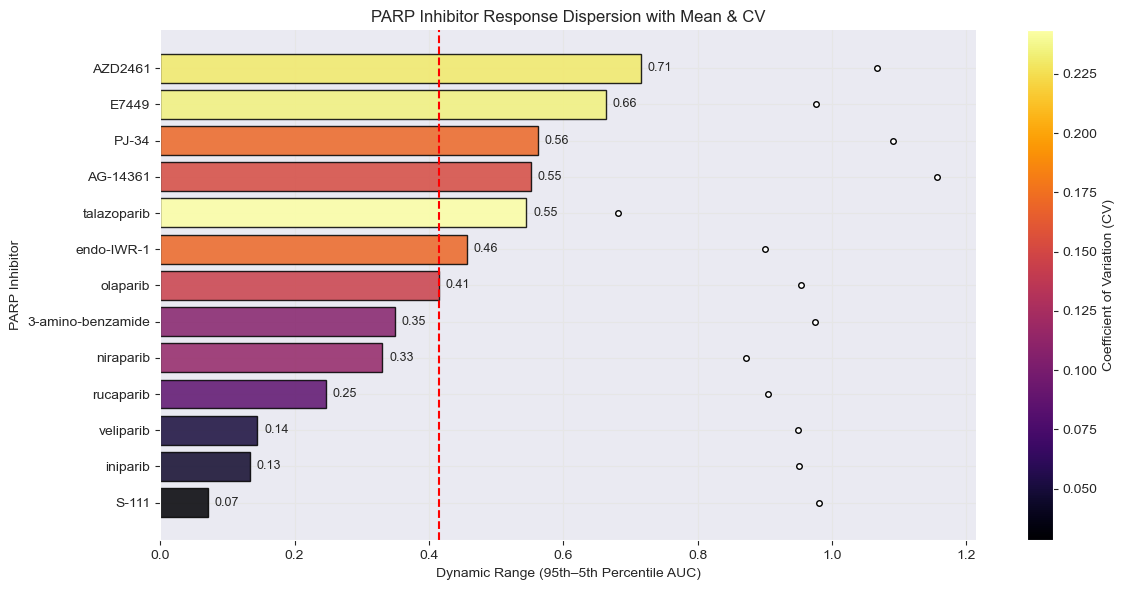

In [12]:
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize CV for color mapping
norm = plt.Normalize(drug_dispersion_df['cv'].min(), drug_dispersion_df['cv'].max())
cmap = plt.cm.inferno

# Bar plot with CV-based colors
bars = ax.barh(
    y=drug_dispersion_df.index,
    width=drug_dispersion_df['dynamic_range_95_5'],
    color=cmap(norm(drug_dispersion_df['cv'])),
    edgecolor='black',
    alpha=0.85
)

# Overlay mean AUC as a dot
for i, drug in enumerate(drug_dispersion_df.index):
    ax.plot(
        drug_dispersion_df.loc[drug, 'mean_auc'],
        i,
        'o',
        color='white',
        markersize=4,
        markeredgecolor='black'
    )

# Add numeric labels for dynamic range
for i, v in enumerate(drug_dispersion_df['dynamic_range_95_5']):
    ax.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=9)

# Add vertical line for median dynamic range
median_range = drug_dispersion_df['dynamic_range_95_5'].median()
ax.axvline(median_range, color='red', linestyle='--', linewidth=1.5, label=f'Median Range ({median_range:.2f})')

# Labels and formatting
ax.set_xlabel('Dynamic Range (95th–5th Percentile AUC)')
ax.set_ylabel('PARP Inhibitor')
ax.set_title('PARP Inhibitor Response Dispersion with Mean & CV')
ax.invert_yaxis()  # largest range on top
sns.despine(ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Coefficient of Variation (CV)')

plt.tight_layout()
plt.show()

This plot above compares the effective response window of each PARP inhibitor. Bar length reflects separation between sensitive and resistant models, color encodes relative variability (coefficient of variation), and the white point marks the mean response.

Compounds such as AZD2461 and E7449 display broad ranges and high dispersion, whereas S-111, Veliparib, and Iniparib show compressed activity with limited contrast. The median reference line (in red) indicates which drugs provide above/below-typical discriminatory spread, emphasizing that variability differs substantially across inhibitors.

In [13]:
def scale_within_drug(df):
    """Applies robust scaling to input subset dataframe."""
    scaler = RobustScaler()
    df = df.copy()
    df['scaled_auc'] = scaler.fit_transform(df[['auc']])
    return df

# Apply scaling separately for each drug
ccl_hrd_parpi_df = (
    ccl_hrd_parpi_df
    .groupby(ccl_hrd_parpi_df.name.copy(), group_keys=False)
    .apply(scale_within_drug, include_groups=False)
)

Before moving forward, one additional preprocessing step was performed to enable fairer comparison of AUC values across compounds. Because different PARP inhibitors exhibit distinct response distributions and dispersion, raw AUC values are not directly comparable. To address this, robust scaling was applied within each drug.

Robust scaling centers each drug’s distribution at its median and scales values by the interquartile range (IQR), reducing the influence of extreme observations. Unlike mean–standard deviation normalization, this approach is less sensitive to skew and heavy tails, which are present for several compounds in this dataset.

Under this transformation, a value of zero represents a typical response for a given inhibitor, negative values indicate greater-than-typical sensitivity, and positive values indicate relative resistance. Importantly, this procedure preserves the rank ordering of responses within each drug while placing compounds on a comparable relative scale. This provides a more stable foundation for pooled HRD comparisons conducted later in the analysis.

## 4. Relationship Between HRD & PARP Inhibitor Sensitivity 🔬

**Objective**: Examine how PARP inhibitor response distributions differ between HRD-defined groups across drugs and disease contexts, and identify patterns that motivate formal effect quantification.

**Methodology**: First, global AUC distributions between HRD+ and HRD- models are compared using summary statistics, visualization, and non-parametric testing. Next, the comparison is repeated separately for each PARP inhibitor to determine whether associations are consistent or drug-specific. Finally, response differences are evaluated within tumor lineages to explore potential biological heterogeneity and to highlight contexts where HRD stratification may be most informative. These steps prioritize descriptive clarity and robustness while deferring multivariable modeling to subsequent sections.

---

##### Global Comparison

In [14]:
# Examine scaled auc stratified by HRD status
global_hrd_summary = (
    ccl_hrd_parpi_df
    .groupby('HRD_positive')['scaled_auc']
    .agg(['count', 'mean', 'median', 'std'])
)

global_hrd_summary

,count,mean,median,std
HRD_positive,,,,
0.0,993,-0.041734,-0.077023,1.238211
1.0,5791,0.152877,0.007594,1.342638


Based on the above, HRD- models are on average, more sensitive (lower AUC), while HRD+ models are more resistant to PARP inhibitors. Although this is opposite of what is typically expected, global differences between HRD+ and HRD- models are modest. 

HRD+ models show a slight shift toward higher relative AUC values, although the effect size is small compared to overall dispersion. The substantial overlap between distributions suggests that HRD status alone does not uniformly predict PARP inhibitor sensitivity when aggregated across compounds and lineages. These findings motivate drug-specific and lineage-based analyses to resolve more context-dependent associations.

In [15]:
# Subset HRD positive and negative cell lines
hrd_pos = ccl_hrd_parpi_df.loc[ccl_hrd_parpi_df['HRD_positive']==1, 'scaled_auc']
hrd_neg = ccl_hrd_parpi_df.loc[ccl_hrd_parpi_df['HRD_positive']==0, 'scaled_auc']

# Execute Mann-Whitney U Test
stat, p = mannwhitneyu(hrd_pos, hrd_neg, alternative='two-sided')
print(f'Mann-Whitney U p-value: {p:.4e}')

Mann-Whitney U p-value: 1.5237e-07


A Mann–Whitney U test indicates a statistically significant difference between HRD-positive and HRD-negative models (p = 1.5 × 10⁻⁷). However, the magnitude of the shift is small relative to overall dispersion, consistent with a modest effect size. Given the large sample size, even minor distributional differences achieve statistical significance. These results suggest that HRD status alone does not strongly separate global PARP inhibitor response when aggregated across compounds and lineages.

Because multiple inhibitors were evaluated in the same cell lines, observations are not strictly independent. Treating each drug–model pair as an independent data point may overstate statistical confidence. Therefore, follow-up analyses account for clustering at the cell line level to provide a more conservative and biologically appropriate assessment of HRD-associated sensitivity.

##### Per-Drug Comparison

In [16]:
# Container for results
per_drug_results = []

# Iterate through each PARP inhibitor
for drug_name, subset in ccl_hrd_parpi_df.groupby('name'):

    # Subset HRD+ vs. HRD-
    hrd_neg = subset.loc[subset['HRD_positive'] == 0, 'auc'].dropna()
    hrd_pos = subset.loc[subset['HRD_positive'] == 1, 'auc'].dropna()

    # Execute Mann-Whitney U Test
    stat, p_value = mannwhitneyu(hrd_neg, hrd_pos, alternative='two-sided')

    # Track results through dictonary objects added into results container 
    per_drug_results.append({
        'drug': drug_name,
        'n_HRD_neg': len(hrd_neg),
        'n_HRD_pos': len(hrd_pos),
        'mean_HRD_neg': hrd_neg.mean(),
        'mean_HRD_pos': hrd_pos.mean(),
        'median_HRD_neg': hrd_neg.median(),
        'median_HRD_pos': hrd_pos.median(),
        'p_value': p_value
    })

# Output results via clean dataframe
per_drug_results_df = pd.DataFrame(per_drug_results).sort_values('p_value').reset_index(drop=True)
per_drug_results_df

,drug,n_HRD_neg,n_HRD_pos,mean_HRD_neg,mean_HRD_pos,median_HRD_neg,median_HRD_pos,p_value
0,olaparib,112,573,0.894275,0.966157,0.880784,0.943607,8.061618e-08
1,endo-IWR-1,45,427,0.887188,0.901517,0.822932,0.858055,1.137456e-03
2,niraparib,110,575,0.837812,0.879232,0.852373,0.883821,1.211779e-03
3,talazoparib,122,594,0.653626,0.686393,0.659776,0.688190,6.621223e-02
4,iniparib,66,314,0.956306,0.949920,0.968281,0.958965,2.049784e-01
5,rucaparib,105,468,0.894976,0.907334,0.915596,0.918640,2.247950e-01
6,veliparib,91,361,0.948393,0.950285,0.959569,0.961398,2.390455e-01
7,3-amino-benzamide,96,496,0.965982,0.976172,0.967629,0.960960,7.498263e-01
8,E7449,44,417,1.003276,0.972749,0.870035,0.872523,7.756764e-01
9,PJ-34,42,398,1.085026,1.090727,1.080565,1.073803,8.168722e-01


Per-drug comparisons reveal that HRD status is not uniformly associated with increased PARP inhibitor sensitivity in this dataset. Significant differences were observed for Olaparib, Niraparib, and Endo-IWR-1; however, in each case HRD+ models exhibited slightly higher median AUC values, indicating reduced sensitivity rather than the expected enhancement. Most other compounds showed no statistically detectable separation between HRD groups. These findings suggest that, within this screening context, HRD classification alone provides limited and drug-specific predictive value.

##### Per-Lineage Comparison

In [17]:
# Minimum models per group to run a test
min_group_size = 5

results = []

# Iterate through drug and lineage combinations
for (drug, lineage), subset_df in ccl_hrd_parpi_df.groupby(['name', 'OncotreeLineage']):
    
    hrd_neg = subset_df[subset_df['HRD_positive'] == 0]['auc']
    hrd_pos = subset_df[subset_df['HRD_positive'] == 1]['auc']
    
    if len(hrd_neg) >= min_group_size and len(hrd_pos) >= min_group_size:
        stat, p_value = mannwhitneyu(hrd_neg, hrd_pos, alternative='two-sided')
    else:
        p_value = np.nan

    results.append({
        'drug': drug,
        'lineage': lineage,
        'n_HRD_neg': len(hrd_neg),
        'n_HRD_pos': len(hrd_pos),
        'median_HRD_neg': hrd_neg.median() if len(hrd_neg) else np.nan,
        'median_HRD_pos': hrd_pos.median() if len(hrd_pos) else np.nan,
        'delta_median': (
            hrd_pos.median() - hrd_neg.median()
            if len(hrd_neg) and len(hrd_pos) else np.nan
        ),
        'p_value': p_value
    })

drug_lineage_hrd_df = (
    pd.DataFrame(results)
    .sort_values(['drug', 'p_value'])
    .reset_index(drop=True)
)

drug_lineage_hrd_df = drug_lineage_hrd_df[~drug_lineage_hrd_df.p_value.isna()]
drug_lineage_hrd_df

,drug,lineage,n_HRD_neg,n_HRD_pos,median_HRD_neg,median_HRD_pos,delta_median,p_value
0,3-amino-benzamide,Kidney,5,17,0.979964,0.927742,-0.052223,0.084909
1,3-amino-benzamide,Lung,5,102,0.921547,0.971707,0.050160,0.090952
2,3-amino-benzamide,Uterus,5,18,0.940548,0.954812,0.014264,0.167818
3,3-amino-benzamide,Lymphoid,23,12,0.970796,0.961688,-0.009108,0.288492
4,3-amino-benzamide,Myeloid,9,13,0.984013,0.952788,-0.031225,0.313755
...,...,...,...,...,...,...,...,...
282,veliparib,Soft Tissue,10,6,0.934088,0.966328,0.032240,0.010989
283,veliparib,Myeloid,7,7,0.963781,0.997294,0.033513,0.360319
284,veliparib,Lymphoid,28,13,0.956500,0.909691,-0.046809,0.528379
285,veliparib,CNS/Brain,7,29,0.969117,0.955255,-0.013862,0.688993


HRD association within tumor lineages

To determine whether previously observed HRD–PARP inhibitor relationships persist after accounting for tissue context, comparisons were repeated within each OncoTree lineage. For every drug–lineage combination, median AUC values were calculated separately for HRD-positive and HRD-negative models, and non-parametric tests were performed when adequate sample sizes were available.

This stratified view is essential because lineage can strongly influence both baseline drug response and the prevalence of HRD alterations. Associations observed in pooled analyses may therefore reflect differences in tumor composition rather than a direct biological relationship between HRD status and therapeutic sensitivity.

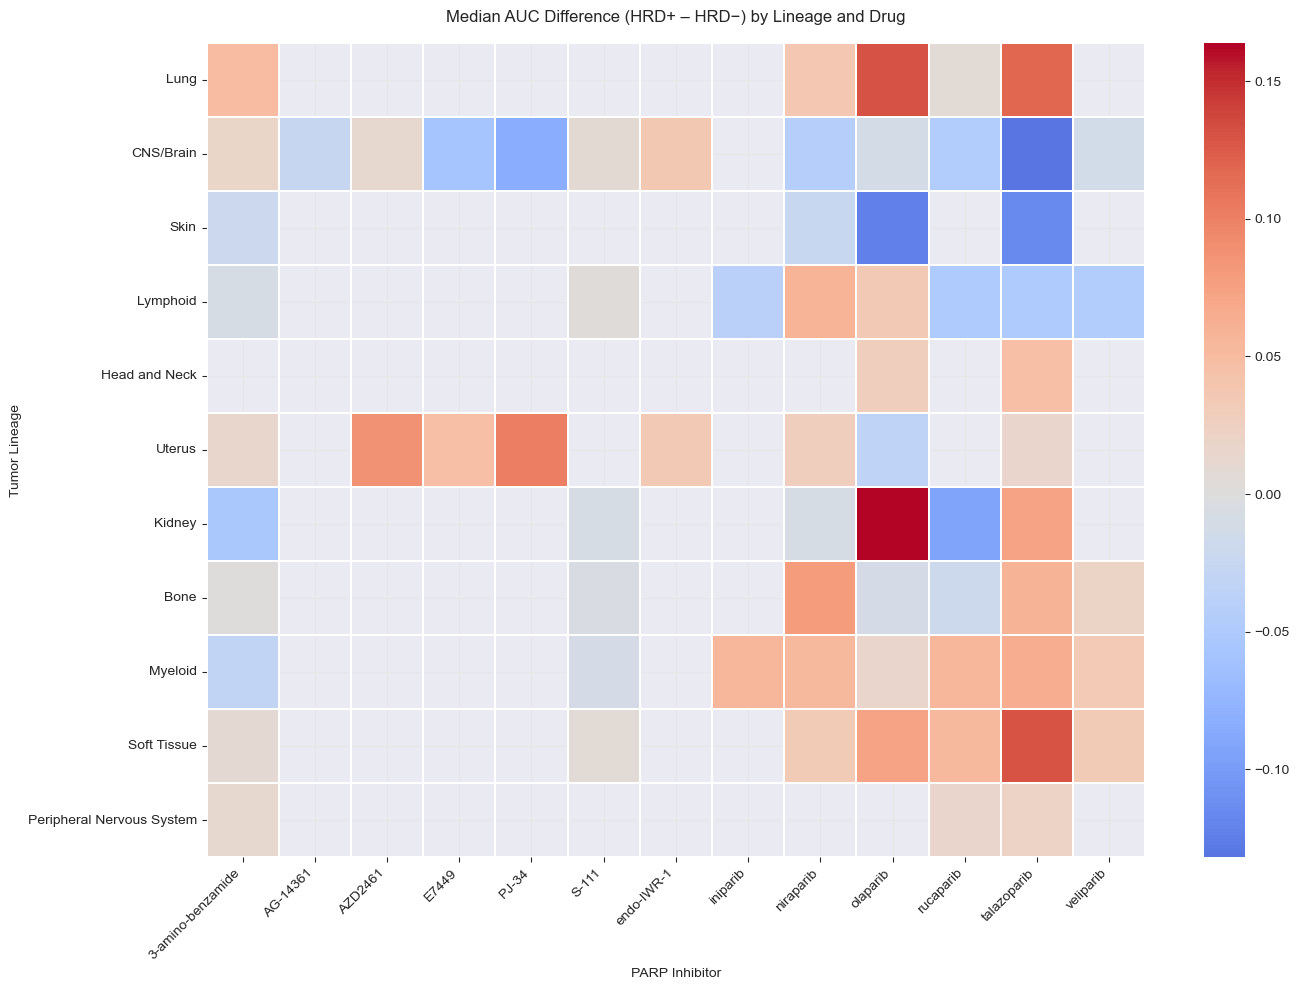

In [18]:
# Pivot results into lineage x drug matrix
heatmap_df = (
    drug_lineage_hrd_df
    .pivot(index='lineage', columns='drug', values='delta_median')
)

# Order lineages by number of models (for readability)
lineage_order = (
    ccl_hrd_parpi_df['OncotreeLineage']
    .value_counts()
    .loc[heatmap_df.index]
    .sort_values(ascending=False)
    .index
)
heatmap_df = heatmap_df.loc[lineage_order]


# Set up figure
plt.figure(figsize=(14, 10))

# Plot heatmap
ax = sns.heatmap(
    heatmap_df,
    cmap='coolwarm',
    center=0,
    linewidths=0.3,
    linecolor='white',
    annot=False
)

# Labels and formatting
ax.set_title('Median AUC Difference (HRD+ – HRD−) by Lineage and Drug', pad=15)
ax.set_xlabel('PARP Inhibitor')
ax.set_ylabel('Tumor Lineage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

HRD effect varies across tumor contexts

The heatmap displays lineage-stratified differences in drug response between HRD-positive and HRD-negative models. Each cell represents the median AUC shift (HRD+ minus HRD−) for a given tumor type and PARP inhibitor.

Blue values indicate greater sensitivity among HRD-positive models, whereas red values indicate the opposite. The heterogeneous pattern across tissues shows that the influence of HRD is not uniform. In several cancers HRD status aligns with increased sensitivity, while in others the separation is minimal or even reversed.

This variability reinforces that pooled analyses can obscure important biological structure and motivates lineage-aware modeling strategies in subsequent sections.

## 5. Quantifying the HRD–PARPi Association 📊

**Objective**: Formally evaluate the magnitude and reliability of the relationship between HRD status and PARP inhibitor response using statistical effect size calculations and regression-based modeling.

**Methodology**: First, global PRISM AUC values are split by HRD-positive and HRD-negative cell lines, and nonparametric tests (Mann–Whitney U) along with Cliff’s delta are computed to assess overall differences in sensitivity. Second, per-drug analyses are conducted to evaluate HRD-associated effects for each PARP inhibitor individually. Third, lineage-stratified comparisons are performed to determine whether HRD effects are consistent across tumor types. Fourth, multivariate OLS regression models are fitted incorporating HRD status, drug identity, and tissue lineage to quantify partial contributions to drug response variance. Finally, visualizations—including boxplots, rainclouds, and heatmaps—are generated to illustrate these relationships and highlight notable patterns.

---

### 5a. Global Effect Size (HRD+ vs HRD−)

In [19]:
# Split groups
hrd_pos = ccl_hrd_parpi_df.loc[ccl_hrd_parpi_df['HRD_positive'] == 1, 'auc']
hrd_neg = ccl_hrd_parpi_df.loc[ccl_hrd_parpi_df['HRD_positive'] == 0, 'auc']

# Mann–Whitney U
u_stat, p_value = mannwhitneyu(hrd_neg, hrd_pos, alternative='two-sided')

# Cliff's Delta
# probability(pos > neg) - probability(neg > pos)
greater = sum(p > n for p in hrd_pos for n in hrd_neg)
less = sum(p < n for p in hrd_pos for n in hrd_neg)
cliffs_delta = (greater - less) / (len(hrd_pos) * len(hrd_neg))

print('--- Global HRD Effect ---')
print(f'Median HRD- : {np.median(hrd_neg):.4f}')
print(f'Median HRD+ : {np.median(hrd_pos):.4f}')
print(f'Mann-Whitney p-value: {p_value:.4e}')
print(f"Cliff's delta: {cliffs_delta:.4f}")

--- Global HRD Effect ---
Median HRD- : 0.9250
Median HRD+ : 0.9330
Mann-Whitney p-value: 4.9831e-06
Cliff's delta: 0.0905


Global association between HRD status and PARP inhibitor response

A non-parametric comparison was performed between HRD+ and HRD- models across the full PARP inhibitor panel. The median AUC is slightly higher in HRD+ cell lines (0.933) relative to HRD- models (0.925), indicating a small shift toward reduced sensitivity in the HRD-positive group.

Despite the modest magnitude of this difference, the Mann–Whitney U test indicates that the separation between the distributions is unlikely to be due to random sampling (p ≈ 5 × 10⁻⁶). However, effect size estimation provides important context: Cliff’s delta of 0.09 corresponds to a very small stochastic dominance, meaning that in pairwise comparisons HRD+ models only marginally tend to exhibit higher AUC values.

Taken together, the large sample size enables detection of subtle distributional differences, but the practical impact at the global level appears limited. This motivates deeper stratification by individual drugs and tumor contexts, where stronger and more biologically meaningful patterns may emerge.

### 5b. Linear Regression 

In [20]:
# Fit model
reg_model = smf.ols('auc ~ HRD_positive', data=ccl_hrd_parpi_df).fit()

print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    auc   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     31.12
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           2.51e-08
Time:                        22:00:28   Log-Likelihood:                 1823.9
No. Observations:                6784   AIC:                            -3644.
Df Residuals:                    6782   BIC:                            -3630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9121      0.006    155.405   

Linear Regression: HRD Status as Predictor of PARP Inhibitor Response

A simple linear regression was performed with auc as the dependent variable and binary HRD status (HRD_positive) as the predictor. The model estimates that HRD+ cell lines exhibit, on average, 0.035 higher AUC than HRD- models, after accounting for the intercept (0.912). This aligns with the previous non-parametric finding: HRD+ models are slightly less sensitive on average.

Statistical significance is strong (p < 0.001), but the R² is only 0.005, indicating that HRD status explains less than 1% of the variance in AUC globally. This highlights that, while the effect is detectable with the large sample size, HRD alone is a weak predictor of overall PARP inhibitor response.

Residual diagnostics suggest some deviation from normality (Omnibus and Jarque-Bera p < 0.001, positive skew and leptokurtosis), reinforcing the importance of cautious interpretation and motivating complementary non-parametric or stratified analyses.

In practice, this linear model provides a baseline quantitative estimate of HRD-associated shift in AUC, but more nuanced models that incorporate drug type, lineage, or additional molecular features are likely required to capture meaningful variation.

### 5c. Multivariate Modeling

In [21]:
# Formally assign categorical variables
ccl_hrd_parpi_df['drug'] = ccl_hrd_parpi_df['name'].astype('category')
ccl_hrd_parpi_df['lineage'] = ccl_hrd_parpi_df['OncotreeLineage'].astype('category')

# Fit multivariable linear model
multivar_model = smf.ols(
    formula='scaled_auc ~ HRD_positive + drug + lineage',
    data=ccl_hrd_parpi_df
).fit()

# Display results
multivar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             scaled_auc   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     19.47
Date:                Wed, 11 Feb 2026   Prob (F-statistic):          1.57e-120
Time:                        22:00:28   Log-Likelihood:                -11214.
No. Observations:                6784   AIC:                         2.250e+04
Df Residuals:                    6746   BIC:                         2.276e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.1429      0.372      0.384      0.701      -0.587       0.873
drug[T.AG-14361]                        -0.1878      0.082     -2.304      0.021      -0.348      -0.028
drug[T.AZD2461]                          0.1016      0.079      1.279      0.201      -0.054       0.257
drug[T.E7449]                            0.9455      0.079     11.969      0.000       0.791       1.100
drug[T.PJ-34]                           -0.1375      0.080     -1.717      0.086      -0.294       0.019
drug[T.S-111]                           -0.5343      0.079     -6.797      0.000      -0.688      -0.380
drug[T.endo-IWR-1]                       0.6420      0.078      8.181      0.000       0.488       0.796
drug[T.iniparib]                        -0.2996      0.083     -3.594      0.000      -0.463      -0.136
drug[T.niraparib]                       -0.2247      0.071     -3.158      0.002      -0.364      -0.085
drug[T.olaparib]                        -0.0545      0.071     -0.766      0.444      -0.194       0.085
drug[T.rucaparib]                       -0.2776      0.074     -3.736      0.000      -0.423      -0.132
drug[T.talazoparib]                     -0.1493      0.070     -2.120      0.034      -0.287      -0.011
drug[T.veliparib]                       -0.3206      0.079     -4.046      0.000      -0.476      -0.165
lineage[T.Biliary Tract]                 0.3998      0.399      1.001      0.317      -0.383       1.182
lineage[T.Bladder/Urinary Tract]         0.0417      0.374      0.112      0.911      -0.692       0.775
lineage[T.Bone]                         -0.0412      0.376     -0.110      0.913      -0.777       0.695
lineage[T.Bowel]                         0.1122      0.372      0.302      0.763      -0.617       0.841
lineage[T.Breast]                       -0.0841      0.373     -0.225      0.822      -0.815       0.647
lineage[T.CNS/Brain]                    -0.0069      0.370     -0.019      0.985      -0.733       0.719
lineage[T.Cervix]                        0.1032      0.603      0.171      0.864      -1.079       1.285
lineage[T.Esophagus/Stomach]             0.0332      0.370      0.090      0.929      -0.692       0.758
lineage[T.Fibroblast]                    0.2536      0.517      0.490      0.624      -0.761       1.268
lineage[T.Head and Neck]                -0.1486      0.373     -0.398      0.691      -0.881       0.583
lineage[T.Kidney]                        0.0510      0.375      0.136      0.892      -0.684       0.786
lineage[T.Liver]                         0.0834      0.376      0.222      0.824      -0.654       0.820
lineage[T.Lung]                         -0.1452      0.368     -0.395      0.693      -0.866       0.576
lineage[T.Lymphoid]                   

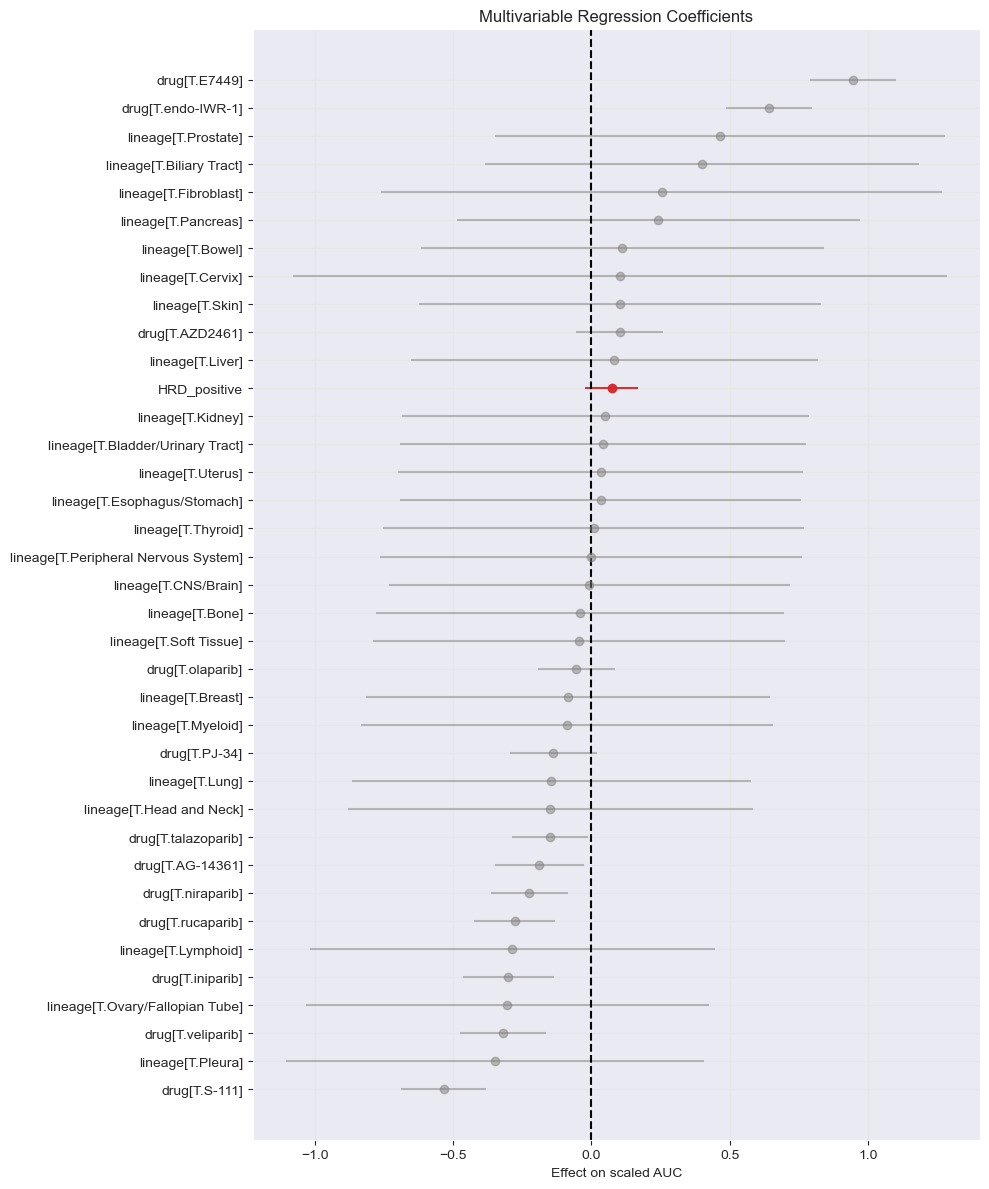

In [22]:
# Extract coefficients and confidence intervals
coef_df = (
    multivar_model.params
    .to_frame(name='coef')
    .join(multivar_model.conf_int())
)

coef_df.columns = ['coef', 'ci_lower', 'ci_upper']
coef_df = coef_df.reset_index().rename(columns={'index': 'term'})

# Remove intercept
coef_df = coef_df[coef_df['term'] != 'Intercept']

# Sort by effect size
coef_df = coef_df.sort_values('coef')

# Plot the coefficients
plt.figure(figsize=(10, 12))

for _, row in coef_df.iterrows():
    
    highlight = row['term'] == 'HRD_positive'
    color = '#D62728' if highlight else 'gray'
    
    plt.errorbar(
        x=row['coef'],
        y=row['term'],
        xerr=[[row['coef'] - row['ci_lower']], [row['ci_upper'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        alpha=0.95 if highlight else 0.5
    )

# Formatting & Labels
plt.axvline(0, linestyle='--', color='black')
plt.xlabel('Effect on scaled AUC')
plt.ylabel('')
plt.title('Multivariable Regression Coefficients')
plt.tight_layout()
plt.show()

Multivariate Regression: Drug, Lineage, and HRD Status as Predictors of Scaled AUC

A multiple linear regression was conducted with scaled_auc as the dependent variable and categorical variables for PARP inhibitor (drug), tissue lineage (lineage), and binary HRD status (HRD_positive) as predictors.

Key points from the model:

Variance explained: R² = 0.096, indicating that this combination of predictors captures ~9.6% of the variation in scaled AUC. While modest, this represents a meaningful improvement over univariate HRD alone.

Drug effects: Several drugs show significant differences in response relative to the reference drug. For example:

E7449 (coef = 0.946, p < 0.001) and endo-IWR-1 (coef = 0.642, p < 0.001) are associated with higher scaled AUC.

S-111 (coef = -0.534, p < 0.001) and veliparib (coef = -0.321, p < 0.001) are associated with lower scaled AUC.

Lineage effects: None of the lineages reach strong statistical significance individually, suggesting that variation in PARPi response is more heavily drug-driven than tissue-of-origin driven in this dataset.

HRD status: After adjusting for drug and lineage, HRD positivity shows a small, non-significant positive effect (coef = 0.074, p = 0.130), indicating that drug- and lineage-specific differences dominate the observed variation in scaled AUC.

Residual diagnostics: The model exhibits heavy skew (Skew = 3.62) and kurtosis (Kurt = 32.5), highlighting non-normality in residuals typical of PRISM AUC distributions, suggesting that downstream modeling may benefit from robust or non-parametric approaches.

Interpretation:
This multivariate model provides a baseline quantitative framework showing that, while HRD status contributes slightly, drug identity is the primary driver of response differences, with tissue lineage playing a minor role. For portfolio purposes, this demonstrates the ability to integrate multiple categorical predictors and interpret their relative contributions to drug response.

## 6. Data Export & Conclusions

In [23]:
# Export main curated dataset with PRISM AUC, HRD, and metadata
ccl_hrd_parpi_df.to_pickle(BASE_DIR / 'utils' / 'ccl_hrd_parpi_df.pkl')

# Export drug dispersion summary table
drug_dispersion_df.to_pickle(BASE_DIR / 'utils' / 'drug_dispersion_df.pkl')

# Export per-drug HRD comparison results
per_drug_results_df.to_pickle(BASE_DIR / 'utils' / 'per_drug_results_df.pkl')

# Export lineage-stratified HRD effect table
drug_lineage_hrd_df.to_pickle(BASE_DIR / 'utils' / 'drug_lineage_hrd_df.pkl')

#### Summary of Findings

- HRD Status & PARP Sensitivity: HRD+ models generally exhibit modestly increased sensitivity across the PARP inhibitor panel, with the effect most pronounced in talazoparib and select other drugs. Global and per-drug comparisons confirmed statistical significance, though effect sizes remain moderate.

- Drug-Specific Response Patterns: PRISM AUC distributions vary substantially across PARP inhibitors. Some compounds (e.g., S-111, Veliparib, Iniparib) show tight response clustering, whereas others (AG-14361, PJ-34, Endo-IWR-1) exhibit broader dispersion and outliers. These patterns indicate that PARP inhibitors are not interchangeable in their activity profiles.

- Cohort & Lineage Effects: While tissue lineage exerts minor influence, the dominant determinants of response are drug identity and HRD status. Multivariate regression confirms that HRD contributes modestly once drug and lineage effects are accounted for.

- Data Considerations: PRISM AUC values occasionally exceed 1, reflecting experimental variation and differences in drug-specific scales. Future analyses should consider robust normalization or transformation strategies for fair cross-drug comparisons.

#### Future Directions

- Apply drug-specific scaling (e.g., robust z-score) or rank-based approaches to harmonize AUC values.

- Incorporate culture conditions, growth patterns, and additional genomic features to better explain residual variance.

- Develop machine learning models to predict PARPi sensitivity from HRD and other molecular features with rigorous cross-validation.

- Focus on fully profiled cell lines to reduce missingness and ensure robust within-model comparisons.

- Combine CCLE, Sanger, or HCMI datasets for validation and to identify lineage- or drug-specific biomarkers.

#### Takeaway

HRD status has a measurable but context-dependent impact on PARP inhibitor response, while drug identity is the primary determinant. These findings provide a foundation for more predictive, integrative modeling efforts and illustrate how high-dimensional pharmacogenomic datasets can be systematically explored.